In [1]:
ls



NameError: name 'ls' is not defined

In [2]:

ls

Mv_tsla.ipynb                          lstm.py
eda/                                   multivariate_btc_LSTM (2)-Copy1.ipynb
lstm.ipynb                             multivariate_btc_LSTM (2).ipynb


In [14]:
from sklearn.preprocessing import MinMaxScaler
import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import csv
import os


# Absolute path and column names for both files
STOCK_DATA = '/Users/sb/Documents/Csv Files/TSLA.csv'
STOCK_FEATURES = ['Date','Open','High','Low','Close','Adj_Close','Volume']

SENTIMENT_DATA = '/Users/sb/Documents/Csv Files/tesla_sentiment.csv'
SENTIMENT_FEATURES = ['Date', 'freq', 'pos', 'neg', 'neu', 'comp']


# Read stock data from csv
data, stock_dates = {}, []
with open(STOCK_DATA, 'r') as f:
    csvreader = csv.reader(f)
    next(csvreader)
    for i, row in enumerate(csvreader):
        date = str(row[0])
        stock_dates.append(date)
        data[date] = [float(item) for item in row[1:]] 
f.close()


sent_dates = {}
with open(SENTIMENT_DATA, 'r') as f:
    csvreader = csv.reader(f)
    for i, row in enumerate(csvreader):
        date = str(row[0])
        if date in stock_dates:
            data[date] += [float(item) for item in row[1:]]
            
        else:
            sent_dates.append(date)
f.close()


In [33]:
len(sent_dates)

116

In [24]:

new_data={}
for i, key in enumerate(data):
    if i == 0:
        new_data[0] = data[key]
        alpha = datetime.date.fromisoformat(key)
    else:
        beta = datetime.date.fromisoformat(key)
        delta = beta - alpha
        new_data[delta.days] = data[key]
    

In [31]:
len(new_data[2])

6

In [20]:
for i, keyval in enumerate(data):
    [print(keyval)]

2019-03-12
2019-03-13
2019-03-14
2019-03-15
2019-03-18
2019-03-19
2019-03-20
2019-03-21
2019-03-22
2019-03-25
2019-03-26
2019-03-27
2019-03-28
2019-03-29
2019-04-01
2019-04-02
2019-04-03
2019-04-04
2019-04-05
2019-04-08
2019-04-09
2019-04-10
2019-04-11
2019-04-12
2019-04-15
2019-04-16
2019-04-17
2019-04-18
2019-04-22
2019-04-23
2019-04-24
2019-04-25
2019-04-26
2019-04-29
2019-04-30
2019-05-01
2019-05-02
2019-05-03
2019-05-06
2019-05-07
2019-05-08
2019-05-09
2019-05-10
2019-05-13
2019-05-14
2019-05-15
2019-05-16
2019-05-17
2019-05-20
2019-05-21
2019-05-22
2019-05-23
2019-05-24
2019-05-28
2019-05-29
2019-05-30
2019-05-31
2019-06-03
2019-06-04
2019-06-05
2019-06-06
2019-06-07
2019-06-10
2019-06-11
2019-06-12
2019-06-13
2019-06-14
2019-06-17
2019-06-18
2019-06-19
2019-06-20
2019-06-21
2019-06-24
2019-06-25
2019-06-26
2019-06-27
2019-06-28
2019-07-01
2019-07-02
2019-07-03
2019-07-05
2019-07-08
2019-07-09
2019-07-10
2019-07-11
2019-07-12
2019-07-15
2019-07-16
2019-07-17
2019-07-18
2019-07-19

In [0]:
# Funtion to turn our time series data into set of sequences where the last value is the intended output of our model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ser = tf.expand_dims(series, axis=-1)
    data = tf.data.Dataset.from_tensor_slices(series)
    data = data.window(window_size + 1, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size + 1))
    data = data.shuffle(shuffle_buffer)
    data = data.map(lambda w: (w[:-1], w[1:]))
    return data.batch(batch_size).prefetch(1)

# Funciton to plot times series
def plot_series(time, series, label, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.grid(True)

# Function to format get model prediction
def model_forecast(model, X, window_size):
    data = tf.data.Dataset.from_tensor_slices(X)
    data = data.window(window_size, shift=1, drop_remainder=True)
    data = data.flat_map(lambda w: w.batch(window_size))
    data = data.batch(32).prefetch(1)
    forecast = model.predict(data)
    return forecast

In [7]:
#```````````````````````````````````````````````````````````````````````````````````````````````` 
#  The following parameters can all be adjusted to change the size/shape of our input tensors
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 window_size = 30               # Length of sequences used to train model
 batch_size = 128               # Number of batches per epoch of training
 shuffle_buffer_size = 100      # Number of points kept in memory to draw samples from
 col_indices = [-1 , 0 , 1 , -2]           # Column indices for desired features
 split_time = 630               # Where split series into training/validation sets
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Create arrays of time series data and numerical dates
X = np.array(data[:, col_indices])
time = np.array([i for i, day in enumerate(dates)])

# Split into training and validation sets
time_train, x_train = time[:split_time], X[:split_time]
time_valid, x_valid = time[split_time:], X[split_time:]


# Clear metadata and set random seeds for replicability
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Generate data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Build model
model = tf.keras.models.Sequential([
  
  # CONVOLUTIONAL LAYER
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=15,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None,len(col_indices)]),
  # LSTM LAYER
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(30, return_sequences=True)),

  # CONVOLUTIONAL LAYER
  tf.keras.layers.Conv1D(filters=16,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu"),

  # DENSE LAYER
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),

  # LAMBDA LAYER
  tf.keras.layers.Lambda(lambda x: 256.0 * x )
])

# Vary learning rate over our training to find optimal value 
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Stochastic Gradient Descent optimizer
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

# Compile model using Huber loss, SGD and learning rate scheduler
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model.summary()
history = model.fit(train_set, epochs=100, callbacks=[lr_scheduler], verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          3904      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 60)          22800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 60)          21840     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          4816      
_________________________________________________________________
dense (Dense)                (None, None, 64)          1088      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           6

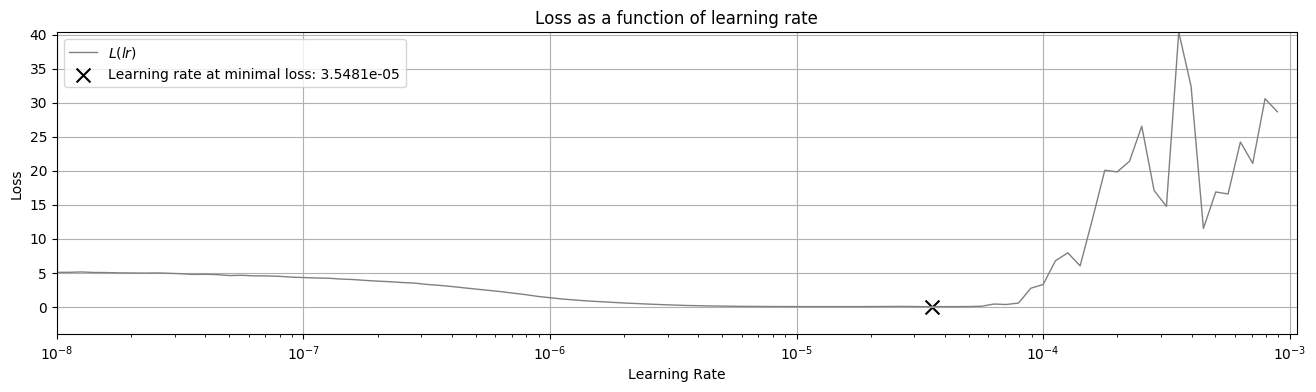

In [8]:
# Calulate optimal learning rate
loss_history = history.history['loss']
lr_history = history.history['lr']
performance = {mae:lr for lr, mae in zip(lr_history, loss_history)}
lr_optimal = performance[min(loss_history)]

# Plot results
plt.figure(figsize=(16,4), dpi=120)
plt.title("Loss as a function of learning rate")
plt.xlabel("Learning Rate")
plt.ylabel('Loss')
plt.semilogx(lr_history, loss_history, label='$L(lr)$', c='gray', lw=1)

# Label minimum loss
plt.scatter([lr_optimal],[min(loss_history)], marker='x', s=100, label = "Learning rate at minimal loss: {}".format('%.4e' % lr_optimal), c='k')
plt.axis([min(lr_history), max(lr_history)+(max(lr_history)-min(lr_history))*0.2, min(loss_history)-(max(loss_history)-min(loss_history))*0.1, max(loss_history)])
plt.legend()
plt.grid()

In [18]:
#```````````````````````````````````````````````````````````````````````````````````````````````` 
#  The following parameters can all be adjusted to change the size/shape of our input tensors
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 window_size = 15               # Length of sequences used to train model
 batch_size = 128               # Number of batches per epoch of training
 shuffle_buffer_size = 100      # Number of points kept in memory to draw samples from
 col_indices = [-1 , 0 , -2]    # Column indices for desired features
 split_time = 630               # Where split series into training/validation sets
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Create arrays of time series data and numerical dates
time = np.array([i for i, day in enumerate(dates)])
X = np.array(data[:, col_indices])

# Split into training and validation sets
time_train, x_train = time[:split_time], X[:split_time]
time_valid, x_valid = time[split_time:], X[split_time:]


# Clear metadata and set random seeds for replicability
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=15,
                         strides=1,
                         padding="causal",
                         activation="relu",
                         input_shape=[None,len(col_indices)]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90, return_sequences=True)),
  tf.keras.layers.Conv1D(filters=64,
                         kernel_size=5,
                         strides=1,
                         padding="causal",
                         activation="relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),  
  tf.keras.layers.Dense(64, activation='tanh'),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: 16.0 * x )
])


# Compile and train the model
model.compile(loss = 'mse',
#    loss = tf.keras.losses.Huber(),
    optimizer = tf.keras.optimizers.SGD(
        lr = lr_optimal,
        momentum = 0.9),
    metrics = ["mae"])
model.summary()
history = model.fit(train_set, epochs = 150, verbose = 1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 64)          2944      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 180)         111600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          57664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         46000     
_________________________________________________________________
dense (Dense)                (None, None, 64)          6464      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           65        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

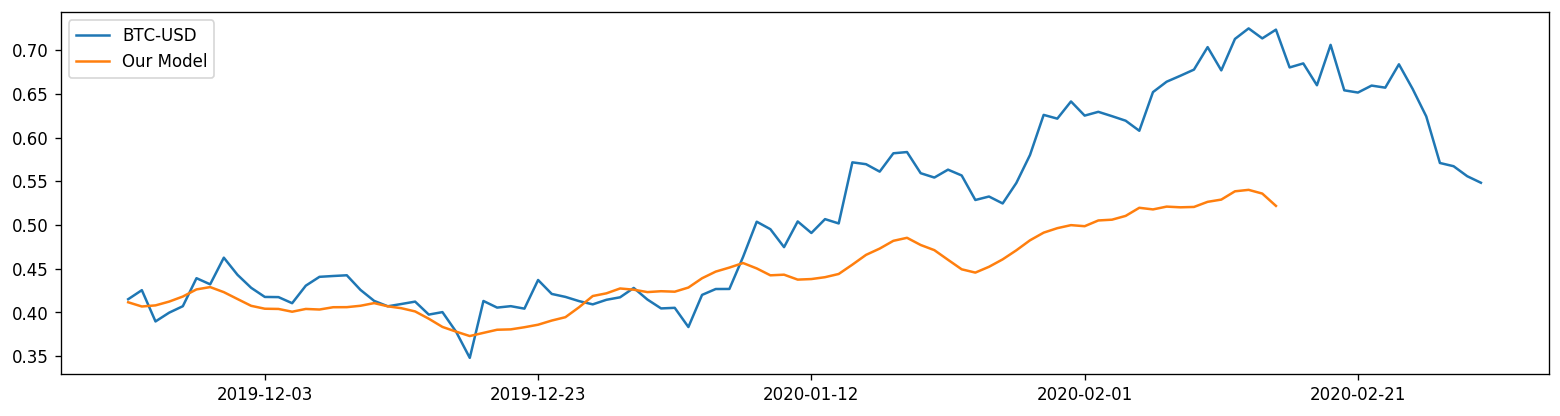

In [22]:
forecast = model_forecast(model, x_valid[...], window_size)
plt.figure(figsize = (16, 4), dpi=120)
plt.plot(time_valid, x_valid[:, 0], label="BTC-USD")
plt.plot(time_valid[:-window_size], forecast[:-1,-1,0], label='Our Model')
plt.xticks([i*20+600 for i in range(2,7)],labels = [dates[i*20+600] for i in range(2,7)])
plt.legend()

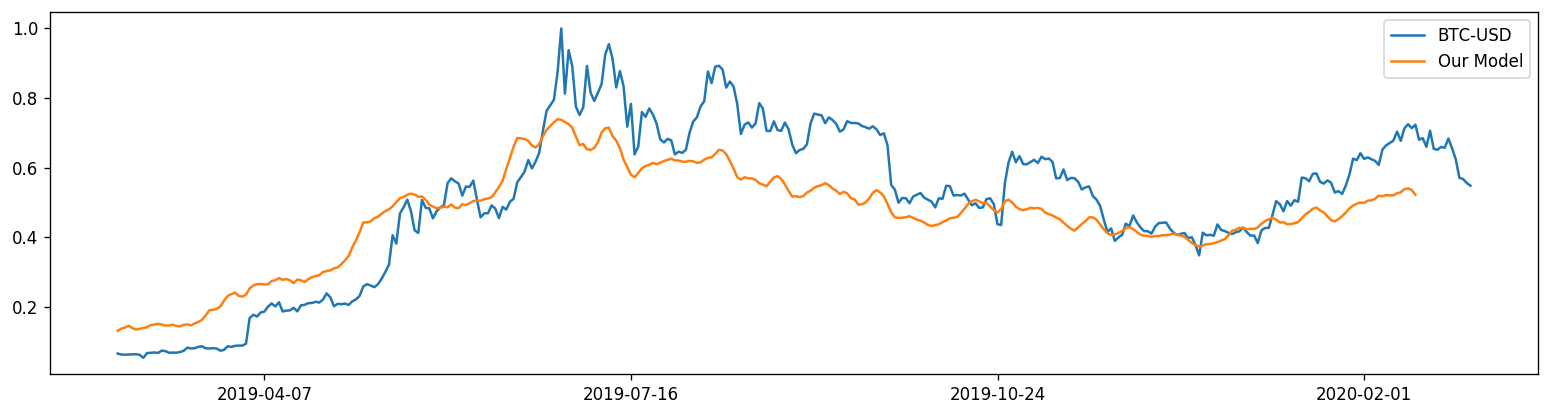

In [24]:

forecast = model_forecast(model, X[...], window_size)
plt.figure(figsize = (16, 4), dpi=120)
plt.plot(time[360:], X[360:, 0], label="BTC-USD")
plt.plot(time[360:-window_size], forecast[360:-1,-1,0], label='Our Model')
plt.xticks([i*100 for i in range(4,8)],labels = [dates[i*100] for i in range(4,8)])
plt.legend()